In [29]:
import networkx as nx
import custom_funcs as cf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from time import time
from collections import defaultdict, Counter
from joblib import Parallel, delayed
from Bio import SeqIO
from Levenshtein import distance
from random import shuffle
from scipy.stats import percentileofscore

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Read in the graph data and clean it.
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.clean_host_species_names(G)
G = cf.impute_reassortant_status(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [31]:
all_hosts = set([d['host_species'] for n, d in G.nodes(data=True)])
len(all_hosts)

152

In [32]:
len(G.edges())

25683

In [33]:
cf.count_edges(G, attr='host_species')

{'full_complement': {'diff_attr': 3114.6333333333328,
  'same_attr': 13106.366666666667},
 'reassortant': {'diff_attr': 1456.0404761904758,
  'same_attr': 735.9595238095236}}

# Compute propotion of edges reassortant same vs. different

In [34]:
# Proportion reassortant in data
data_props = cf.edge_proportion_reassortant(G, attr='host_species')
data_props

{'diff_attr': 0.3185614499893993, 'same_attr': 0.05316732994746787}

In [35]:
# Proportion reassortant under null
excluded_hosts = ['Aquatic Bird', 'Avian', 'Bird', 'Duck', 'Environment', 'Mallard-Black Duck Hybrid', 'Sea Mammal', 
                  'Unknown', 'Waterfowl']
start = time()
def null_distribution_proportion_reassortant(G, equally=False):
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_species', equally)
    props = cf.edge_proportion_reassortant(G_shuffled, 'host_species', exclusions=excluded_hosts)
    return props

props_null = Parallel(n_jobs=-1)(delayed(null_distribution_proportion_reassortant)(G, equally=True) for i in range(100))
end = time()
print(end - start)

181.30580973625183


In [36]:
null = pd.DataFrame(props_null)
null.mean()

diff_attr    0.124644
same_attr    0.126298
dtype: float64

In [37]:
data_samediff = pd.DataFrame([data_props])
data_samediff.mean()

diff_attr    0.318561
same_attr    0.053167
dtype: float64

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


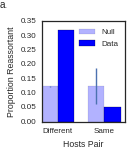

In [38]:
seaborn.set_context("paper")
seaborn.set_style('white')

fig1 = plt.figure(figsize=(1.5,2))
ax1 = fig1.add_subplot(1,1,1)
ind = np.arange(2)
width = 0.35

ax1.bar(ind, null.mean(), width, color='blue', label='Null', alpha=0.3, yerr=null.std()*3)
ax1.bar(ind+width, data_samediff.mean(), width, color='blue', label='Data')
ax1.set_xticks(ind+width)
ax1.set_xticklabels(['Different', 'Same'])
ax1.set_xlabel('Hosts Pair')
ax1.set_ylabel('Proportion Reassortant')
ax1.legend()
ax1.annotate('a.', ha='left', va='top', xy=(0,1), xycoords='figure fraction')
plt.subplots_adjust(left=0.21, bottom=0.2, right=0.98)
plt.savefig('figures/Proportion Reassortant.pdf')

In [39]:
# Compute exact stats
percentileofscore(a=null['same_attr'], score=data_samediff['same_attr'].values)

0.0

In [40]:
null['same_attr'].mean() - data_samediff['same_attr']

0    0.07313
Name: same_attr, dtype: float64

In [41]:
null['diff_attr'].mean() - data_samediff['diff_attr']

0   -0.193917
Name: diff_attr, dtype: float64

# Compute proportion of reassortant by host class

Host classes:

- Wild bird
- Wild mammal
- Domestic bird
- Domestic mammal
- Human

In [42]:
# Open the bird vs. mammal CSV file

host_classes = pd.read_csv('supp_data/host_groups.csv').drop_duplicates()
# I suspected there may have been duplicates, so I added the drop_duplicates() function call.
host_classes.set_index(['Country', 'Species'], inplace=True)
host_classes.ix['Canada'].ix['American Black Duck']

Habitat/setting        Wild
Bird, Mammal, Human    Bird
Name: American Black Duck, dtype: object

In [43]:
# Impute each node with the appropriate metadata. We will create a new node field: "host_class".

# The try/except coding pattern allows me to iteratively identify things for which we have no labels yet.

for n, d in G.nodes(data=True):
    c = d['country']
    s = d['host_species']
    try:
        hc = host_classes.ix[c].ix[s]
        habt = hc['Habitat/setting']
        host = hc['Bird, Mammal, Human']

        host_class = habt + ' ' + host
        G.node[n]['host_class'] = host_class
    except:
        print(c,s)

In [44]:
data_props = cf.edge_proportion_reassortant(G, attr='host_class')
data_props

{'diff_attr': 0.3102622814321399, 'same_attr': 0.10083275503122831}

In [45]:
# A function that computes the proportion reassortant across different node attributes.

def counts_reassortant_domain_graph(G, node_attr):
    """
    Computes the weighted counts of reassortant edges when going between different node attributes.
    
    Returns a "domain graph" with counts of weighted reasosrtant edges and sum weighted edges.
    """
    hg_graph = nx.DiGraph()

    for n, node_d in G.nodes(data=True):

        in_edges = G.in_edges(n, data=True)
        total_edges = len(in_edges)
        is_reassortant = node_d['reassortant']

        sk_hg = G.node[n][node_attr]
        if sk_hg not in hg_graph.nodes():
            hg_graph.add_node(sk_hg)

        for sc, _, edge_d in in_edges:
            sc_hg = G.node[sc][node_attr]
            if sc_hg not in hg_graph.nodes():
                hg_graph.add_node(sc_hg)

            if (sc_hg, sk_hg) not in hg_graph.edges():
                hg_graph.add_edge(sc_hg, sk_hg, total=edge_d['weight'], reassortant=0)
            if (sc_hg, sk_hg) in hg_graph.edges():
                hg_graph.edge[sc_hg][sk_hg]['total'] += edge_d['weight']

            if is_reassortant:
                hg_graph.edge[sc_hg][sk_hg]['reassortant'] += edge_d['weight']

    for sc, sk, d in hg_graph.edges(data=True):
        hg_graph.edge[sc][sk]['p_reassortant'] = d['reassortant'] / d['total']
        
    return hg_graph


In [46]:
# Compute the proportion reassortant across different host class pairs.
hg = counts_reassortant_domain_graph(G, 'host_class')
# We will ignore edges that involve "unknown" hosts.
for n in hg.nodes():
    if 'Unknown' in n:
        hg.remove_node(n)
# hg.edges(data=True)
hg.edges(data=True)

[('Domestic Bird',
  'Domestic Bird',
  {'p_reassortant': 0.1259698582280537,
   'reassortant': 258.4166666666664,
   'total': 2051.416666666666}),
 ('Domestic Bird',
  'Human Human',
  {'p_reassortant': 0.15789473684210473,
   'reassortant': 7.499999999999988,
   'total': 47.500000000000085}),
 ('Domestic Bird',
  'Wild Bird',
  {'p_reassortant': 0.2691511387163561, 'reassortant': 65.0, 'total': 241.5}),
 ('Domestic Bird',
  'Domestic Mammal',
  {'p_reassortant': 0.18454935622317598,
   'reassortant': 10.75,
   'total': 58.25}),
 ('Domestic Bird',
  'Wild Mammal',
  {'p_reassortant': 0.07142857142857142, 'reassortant': 0.5, 'total': 7.0}),
 ('Human Human',
  'Domestic Bird',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 46.0}),
 ('Human Human',
  'Wild Bird',
  {'p_reassortant': 0.14285714285714285, 'reassortant': 1.0, 'total': 7.0}),
 ('Human Human',
  'Human Human',
  {'p_reassortant': 0.0005271481286241308,
   'reassortant': 4.500000000000001,
   'total': 8536.500000000206}),

In [47]:
# A helper function for computing the null distribution.
def null_proportion_domain_graph_reassortant(G, node_attr, equally=False):
    
    G_shuffled = cf.shuffle_node_attribute_label(G, node_attr, equally)
    hg_graph_shuf = counts_reassortant_domain_graph(G_shuffled, node_attr)
    
    return hg_graph_shuf

In [48]:
# Compute the null distribution.
### CAUTION! YOU WILL HAVE TO WAIT 3 MINUTES FOR THIS TO FINISH!
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_domain_graph_reassortant)(G, 'host_class', equally=True) for i in range(100))
len(results)
end = time()
print(end - start)

182.8515269756317


In [49]:
# Summarize the proportion reassortant distribution under null.
def distr_null_p_reassortant(list_of_hg_graphs):
    hg_graph = nx.DiGraph()
    for g in list_of_hg_graphs:
        hg_graph.add_nodes_from(g.nodes())
        for sc, sk, d in g.edges(data=True):
            if (sc, sk) not in hg_graph.edges():
                hg_graph.add_edge(sc, sk, p_reassortant=[d['p_reassortant']])
            else:
                hg_graph.edge[sc][sk]['p_reassortant'].append(d['p_reassortant'])
    return hg_graph

summaryG = distr_null_p_reassortant(results)

In [50]:
# Remove "unknowns" from consideration
for n, d in summaryG.nodes(data=True):
    if 'Unknown' in n:
        summaryG.remove_node(n)
summaryG.nodes(data=True)

[('Domestic Bird', {}),
 ('Human Human', {}),
 ('Wild Bird', {}),
 ('Domestic Mammal', {}),
 ('Wild Mammal', {})]

In [51]:
# Grab out the "null" model statistics.
means = []  # mean of the distribution under null.
stds  = []  # standard deviation of distribution under null.
names = []  # names
# grab out the 1st, 5th, 95th and 99th percentile of null distribution
percs = dict()
for p in [1, 5, 95, 99]:
    percs[p] = []

name_map = {'Domestic Bird': 'DB',
            'Wild Bird': 'WB',
            'Human Human': 'H',
            'Domestic Mammal': 'DM',
            'Wild Mammal': 'WM'}

# Reverse name_map for convenience
key_map = {v:k for k, v in name_map.items()}

for sc, sk, d in sorted(summaryG.edges(data=True), key=lambda x:(x[0], x[1])):
    mean = np.mean(d['p_reassortant'])
    std = np.std(d['p_reassortant'])

    names.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
    means.append(mean)
    stds.append(std)
    for p in [1, 5, 95, 99]:
        percs[p].append(np.percentile(d['p_reassortant'], p))

In [52]:
summaryG.edges(data=True)

[('Domestic Bird',
  'Domestic Bird',
  {'p_reassortant': [0.15204661971320763,
    0.09007088536169422,
    0.11399310335140607,
    0.0915263836183968,
    0.13921526597873324,
    0.1360856510511999,
    0.1354951521137866,
    0.10988846054206867,
    0.14634613465573565,
    0.10979849302354847,
    0.1262898519352346,
    0.13157758930444674,
    0.12325608505207093,
    0.12047250326028243,
    0.13041988081746062,
    0.10660199102894502,
    0.10739834065920502,
    0.11472126315861603,
    0.07065601023191165,
    0.11695633132341533,
    0.09899003873824018,
    0.14725827850189152,
    0.09843229179216717,
    0.1084108655325635,
    0.12068422346314574,
    0.09789021020207335,
    0.12298018909359924,
    0.1199410633852286,
    0.10889273878650452,
    0.13586696243930926,
    0.11514036502537943,
    0.10676177699936659,
    0.08669636272302092,
    0.12228260380486765,
    0.11389632094956745,
    0.1331908162305998,
    0.10397412330321186,
    0.14343581667732067,
  

In [53]:
percs

{1: [0.083041102847311934,
  0.082318056068622206,
  0.078789261497393112,
  0.082391639682564466,
  0.085661691903538756,
  0.079965867863876952,
  0.080513141719821588,
  0.077333776898945175,
  0.079907068249248925,
  0.078484258050161723,
  0.076467794481686474,
  0.083828094642247039,
  0.089092857953168778,
  0.090202181852090196,
  0.081582975064502836,
  0.074394638108986291,
  0.086902082812510634,
  0.090912919501172168,
  0.075047955592973226,
  0.085340611796256502,
  0.084953741941426297,
  0.079325759218647568,
  0.077761542993132579,
  0.086355691199481707,
  0.077035879044624098],
 5: [0.088041480040281284,
  0.086829919553278803,
  0.091131188794239509,
  0.09082595069147234,
  0.089372135965807425,
  0.084902050982449004,
  0.087752021632474739,
  0.089590565852700491,
  0.087958842536300555,
  0.086857320580261438,
  0.08889034397541884,
  0.089890301690864385,
  0.093327962348938392,
  0.096032409919221115,
  0.089041986731759087,
  0.090633665723323667,
  0.0985434

In [54]:
# Compile the "data" statistics.
data = []
names_data = []
log10weights = []
log10reassort = []
log10clonal = []
for sc, sk, d in sorted(hg.edges(data=True), key=lambda x:(x[0], x[1])):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        names_data.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
        data.append(d['p_reassortant'])
        log10weights.append(np.log10(d['total']))
        log10reassort.append(np.log10(d['reassortant']))
        log10clonal.append(np.log10(d['total'] - d['reassortant']))
data

[0.1259698582280537,
 0.18454935622317598,
 0.15789473684210473,
 0.2691511387163561,
 0.07142857142857142,
 0.43157894736842106,
 0.07272017692207625,
 0.047619047619047616,
 0.5263157894736842,
 0.0,
 0.0,
 0.13499999999999981,
 0.0005271481286241308,
 0.14285714285714285,
 0.0,
 0.4435975609756098,
 0.38461538461538464,
 0.6666666666666666,
 0.3061103185924874,
 0.5714285714285714,
 0.5454545454545454,
 0.0,
 0.0,
 0.4642857142857143,
 0.0]

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


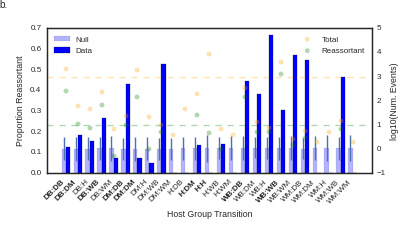

In [76]:
# Plot data vs. null model.
fig = plt.figure(figsize=(5.5,3))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, color='blue', label='Null', yerr=np.array(stds)*3, alpha=0.3)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel('Proportion Reassortant')
ax.set_xlabel('Host Group Transition')

for i, label in enumerate(ax.get_xaxis().get_ticklabels()):
    if log10weights[i] > 3 or log10reassort[i] > 1:
        label.set_weight('bold')

ax2 = ax.twinx()
ax2.scatter(ind+width, log10weights, color='orange', label='Total', alpha=0.3)
ax2.scatter(ind+width, log10reassort, color='green', label='Reassortant', alpha=0.3)
ax2.set_ylabel('log10(Num. Events)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.axhline(y=1, color='green', alpha=0.3, linestyle='--')
ax2.axhline(y=3, color='orange', alpha=0.3, linestyle='--')

ax.annotate('b.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')
# plt.legend()
plt.subplots_adjust(left=0.10, right=0.92, bottom=0.23)
plt.savefig('figures/Proportion Reassortant Ecological.pdf')

In [56]:
!! ls supp_data

['edgelist.csv',
 'host_groups.csv',
 'host_species.csv',
 'hosts_with_classification-NH_EM_mods.csv',
 'patristic_distances.pkl',
 'sequences',
 'trees']

# Compute proportion reassortant over different host COI distances

In [57]:
# Open the host COI data
host_coi = [s for s in SeqIO.parse('supp_data/sequences/host_coi_trimmed.fasta', 'fasta')]
# Modify the SeqRecord ID such that it only contains the host species name.
for s in host_coi:
    s.id = s.id.split('.')[0].replace('_', ' ')
host_coi = SeqIO.to_dict(host_coi)
host_coi

{'American Black Duck': SeqRecord(seq=Seq('ATCCGGGCAGAGCTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCAAATTTAT...TTT', SingleLetterAlphabet()), id='American Black Duck', name='American_Black_Duck.Anas_rubripes', description='American_Black_Duck.Anas_rubripes', dbxrefs=[]),
 'American Green-Winged Teal': SeqRecord(seq=Seq('ATCCGCGCAGAACTAGGCCAACCAGGAACCCTCCTGGGCGACGACCAAATTTAC...TTT', SingleLetterAlphabet()), id='American Green-Winged Teal', name='American_Green-Winged_Teal.Anas_carolinensis', description='American_Green-Winged_Teal.Anas_carolinensis', dbxrefs=[]),
 'American Wigeon': SeqRecord(seq=Seq('ATCCGCGCAGAACTAGGCCAACCAGGGACCCTCCTGGGCGACGACCAAATTTAC...TTT', SingleLetterAlphabet()), id='American Wigeon', name='American_Wigeon.Anas_americana', description='American_Wigeon.Anas_americana', dbxrefs=[]),
 'Baikal Teal': SeqRecord(seq=Seq('ATGGCCCCAAATATCCGCAAATCCCACCCCCTACTAAAAATAATCAACAACTCC...ACC', SingleLetterAlphabet()), id='Baikal Teal', name='Baikal_Teal.Anas_formosa', description='Baikal_T

In [58]:
# Figure out which sequences have gaps. I suspect that the alignment quality might be compromised by those sequences.
ignored = []
for k, sequence in host_coi.items():
    if '-' in str(sequence.seq):
        ignored.append(k)
        print(sequence.seq)
        print(sequence.id)
ignored

-TCCGGGCCGAACTGGGCCAACCTGGTACACTACTAGGAGATGATCAGATTTACAATGTAATCGTCACTGCCCATGCTTTTGTAATGATCTTTTTTATGGTGATGCCTATTATAATTGGAGGGTTCGGAAACTGATTGGTCCCATTAATAATTGGAGCTCCTGACATAGCATTTCCCCGAATAAACAACATGAGCTTCTGACTCCTCCCTTACTCGCCTCATCTATGGTAGAAGCCGAGCAGGAACTGGCTGAACAGTATACCCACCCCTAGCCGGCAACCTGGCTCATGCAGGAGCATCCGTAGACCTAACTATCTTTTCACTACACCTGGCAGGTGTCTCCTCAATCTTGGGTGCTATTAATTTCATTACTACTATTATTAATATAAAACCTCCTGCCATGTCCCAATATCAAACACCTCTATTTGTCTGATCAGTCTTAATCACTGCTGTCTTACTACTTCTATCACTTCCAGTCTTAGCAGCGGGAATCACTATATTACTAACAGATCGAAACCTAAACACCACATTCTTTGACCCCGCTGGGGGAGGAGATCCTATCTTATACCAACACTTATTC
Domestic Cat
ATCCGTGCAGAACTTGGCCAACCCGGAACCCTCCTAGGAGACGACCAAATCTATAACGTAATTGTCACCGCCCATGCCTTCGTGATAATCTTCTTCATAGTGATACCAATCATGATCGGTGGGTTTGGAAACTGACTAGTCCCACTTATAATCGGTGCCCCTGATATAGCATTTCCACGCATAAACAACATAAGCTTCTGACTATTACCCTCCTAGCCTCTTCCACAGTAGAAGCTGAGCCGGCACAGGATGAACAGTATACCCCCCTCTAGCTGGCAATCTAGCTCATGCTGGAGCCTCAGTAGACCTAGCAATCTTCTCTCTTCACTTAGCAGGTGTGTCTTCCATTCTGGGTGCTATCAACTTTATCACTACAGCCATCAACATAAAACCCCCTGCCCTCTCA

['Domestic Cat',
 'Herring Gull',
 'Chicken',
 'Kelp Gull',
 'Redhead',
 'Human',
 'Blue-Winged Teal',
 'Baikal Teal',
 'Cinnamon Teal']

In [59]:
# Impute the COI sequence based on the host species name, ignoring the sequences that have gaps in them. 
for n, d in G.nodes(data=True):    
    try:
        hs = d['host_species']
        assert hs not in ignored
        G.node[n]['coi_sequence'] = host_coi[hs]
    except:
        G.node[n]['coi_sequence'] = None

In [60]:
# Compute proportion under data. 

# Load the patristic distance data.
pds = nx.read_gpickle('supp_data/patristic_distances.pkl')
def proportion_reassortant_coi(G, dist_metric, pds=None):
    """
    Parameters
    - G: the network data, either shuffled or not shuffled.
    - dist_metric: (str) the distance metric.
        - hamming: uses hamming distance between 
    """
    
    assert dist_metric in ['hamming', 'evolutionary']
    
    data = dict()

    if dist_metric == 'hamming':
        bins = np.arange(0,0.3,0.05)  # note: this has been hard-coded
    if dist_metric == 'evolutionary':
        assert isinstance(pds, nx.Graph)
        bins = np.arange(0,1.4,0.1)
        
    for b in bins:
        data[b] = dict()
        data[b]['reassortant'] = 0
        data[b]['clonal'] = 0

    for sc, sk, d in G.edges(data=True):
            
        # Compute the appropriate distance metric.
        if dist_metric == 'hamming':
            sc_coi = G.node[sc]['coi_sequence']
            sk_coi = G.node[sk]['coi_sequence']
            if sc_coi and sk_coi:
                dist = distance(str(sc_coi.seq), str(sk_coi.seq)) / len(str(sc_coi.seq))
                b = bins[int(np.digitize(dist, bins)) - 1] 
                if d['edge_type'] == 'reassortant':
                    data[b]['reassortant'] += d['weight']
                else:
                    data[b]['clonal'] += d['weight']  

        if dist_metric == 'evolutionary':
            sc_host = G.node[sc]['host_species']
            sk_host = G.node[sk]['host_species']
            if pds.has_node(sc_host) and pds.has_node(sk_host):
                dist = pds[sc_host][sk_host]['pd']
                b = bins[int(np.digitize(dist, bins)) - 1]
                if d['edge_type'] == 'reassortant':
                    data[b]['reassortant'] += d['weight']
                else:
                    data[b]['clonal'] += d['weight']  
    return data

coi_data = proportion_reassortant_coi(G, dist_metric='hamming', pds=pds)

In [61]:
coi_data

{0.0: {'clonal': 3010.0000000000036, 'reassortant': 505.95952380952383},
 0.050000000000000003: {'clonal': 360.50000000000006,
  'reassortant': 203.59523809523807},
 0.10000000000000001: {'clonal': 44.0, 'reassortant': 30.0},
 0.15000000000000002: {'clonal': 83.0, 'reassortant': 88.33333333333334},
 0.20000000000000001: {'clonal': 38.0, 'reassortant': 5.5},
 0.25: {'clonal': 0, 'reassortant': 0}}

In [62]:
# Temporary cell
prop_reassortant = dict()
for k, v in coi_data.items():
    try:
        prop_reassortant[k] = v['reassortant'] / (v['clonal'] + v['reassortant'])
    except:
        prop_reassortant[k] = 0
prop_reassortant

{0.0: 0.1439036827310568,
 0.050000000000000003: 0.36092351848725307,
 0.10000000000000001: 0.40540540540540543,
 0.15000000000000002: 0.5155642023346304,
 0.20000000000000001: 0.12643678160919541,
 0.25: 0}

In [63]:
# Compute proportion under null: shuffle host COIs
def null_proportion_reassortant_coi(G, dist_metric, pds):
    if dist_metric == 'hamming':
        trait = 'coi_sequence'
    if dist_metric == 'evolutionary':
        trait = 'host_species'
    
    host_trait = [d[trait] for n, d in G.nodes(data=True)]
    shuffle(host_trait)

    G_shuffled = G.copy()
    for i, (n, d) in enumerate(G_shuffled.nodes(data=True)):
        G_shuffled.node[n][trait] = host_trait[i]    

    return proportion_reassortant_coi(G_shuffled, dist_metric, pds)    

In [64]:
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_reassortant_coi)(G, dist_metric='hamming', pds=pds) for i in range(500))
end = time()
print(end - start)

883.6320080757141


In [65]:
# View the results of permutation test simulation
results

[{0.0: {'clonal': 484.9231055900608, 'reassortant': 62.35119047619048},
  0.050000000000000003: {'clonal': 119.60220841959976,
   'reassortant': 20.59722222222225},
  0.10000000000000001: {'clonal': 45.986111111111114, 'reassortant': 3.75},
  0.15000000000000002: {'clonal': 187.1953703703704,
   'reassortant': 21.083333333333336},
  0.20000000000000001: {'clonal': 656.9961341154817,
   'reassortant': 75.93333333333338},
  0.25: {'clonal': 1.0, 'reassortant': 0}},
 {0.0: {'clonal': 460.177379802162, 'reassortant': 55.35},
  0.050000000000000003: {'clonal': 153.98859558316082,
   'reassortant': 12.819444444444443},
  0.10000000000000001: {'clonal': 35.45238095238095, 'reassortant': 4.5},
  0.15000000000000002: {'clonal': 202.3647342995169, 'reassortant': 20.25},
  0.20000000000000001: {'clonal': 730.5910812054291,
   'reassortant': 83.2900793650794},
  0.25: {'clonal': 2.0, 'reassortant': 0}},
 {0.0: {'clonal': 398.84563492063506, 'reassortant': 73.23055555555555},
  0.050000000000000003

In [66]:
# Aggregate the results into clonal and reassortant

agg = dict()
agg['clonal'] = defaultdict(list)
agg['reassortant'] = defaultdict(list)

for result in results:
    for dist, d in result.items():
        agg['clonal'][dist].append(d['clonal'])
        agg['reassortant'][dist].append(d['reassortant'])

In [67]:
agg['clonal']

defaultdict(list,
            {0.0: [484.9231055900608,
              460.177379802162,
              398.84563492063506,
              483.8370370370366,
              486.0916781688518,
              451.5659650333562,
              451.65093742811047,
              407.5848136645961,
              461.98996632996597,
              442.16576604554825,
              455.9960432482166,
              462.2858454106275,
              450.29947089947007,
              461.14629211368316,
              442.22024959742316,
              476.958199907982,
              439.1832010582005,
              471.78256613756605,
              440.5480285254193,
              425.67837976033627,
              422.2773924545665,
              437.6595238095228,
              463.8051529790651,
              478.56649413388516,
              396.7159788359782,
              485.5957925005744,
              484.9148792270525,
              477.70224867724806,
              504.55591944287494,
          

In [68]:
agg['reassortant']

defaultdict(list,
            {0.0: [62.35119047619048,
              55.35,
              73.23055555555555,
              61.35198412698415,
              43.96031746031747,
              65.25277777777781,
              66.22619047619051,
              77.33664596273293,
              56.440700483091796,
              67.4284851621808,
              63.96557971014495,
              58.73567977915802,
              62.8153899240856,
              61.771825396825434,
              70.99999999999999,
              63.16309523809523,
              75.31280193236717,
              64.37500000000003,
              59.93333333333338,
              54.18840579710147,
              50.267684610075946,
              63.09722222222224,
              62.76587301587304,
              58.00362318840583,
              61.101328502415456,
              61.42028985507248,
              66.8451518288475,
              68.58792270531403,
              61.68840579710148,
              63.95855762594893

In [69]:
# We want to compute the proportion reassortant under the null.
# Iterate over the clonal. 

prop_null = defaultdict(list)

for d, cts in agg['reassortant'].items():
    for i, ct in enumerate(cts):
        try:
            prop_null[d].append(ct / (ct + agg['clonal'][d][i]))
        except:
            prop_null[d].append(np.nan)
prop_null

defaultdict(list,
            {0.0: [0.11393042012819554,
              0.10736578146681759,
              0.15512444184420052,
              0.11253341821886455,
              0.08293585878897933,
              0.1262585358705223,
              0.1278801223452149,
              0.1594828284608554,
              0.10886836774153233,
              0.1323179863241717,
              0.12301980932017229,
              0.11273177198919596,
              0.12241974403794528,
              0.11812905946136788,
              0.13834216412094677,
              0.11694242720241682,
              0.14638170460917632,
              0.12006731615064599,
              0.11975137917373223,
              0.11292385184391007,
              0.10637648565154666,
              0.12600373878582208,
              0.11919735404597898,
              0.10810073337268228,
              0.13346225125834457,
              0.11228242063848425,
              0.12114895618830224,
              0.12555218141986765,
 

In [70]:
null_mean = pd.DataFrame(prop_null).mean()
null_mean = null_mean.reset_index()
null_mean.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']
null_mean

null_std = pd.DataFrame(prop_null).std()
null_std = null_std.reset_index()
null_std.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

# Null buttom error range = 0.025
null_b = pd.DataFrame(prop_null).quantile(0.01)
null_b = null_b.reset_index()
null_b.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

# Null top error range = 0.975
null_t = pd.DataFrame(prop_null).quantile(0.99)
null_t = null_t.reset_index()
null_t.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


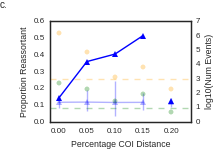

In [71]:
# Plot this data

## 1 November 2015:
## TODO: Rather than plot std*3 or std*5, plot 95% interval from the null. 
## Use the axes.errorbar API: http://matplotlib.org/api/axes_api.html
## [X] DONE



df = pd.DataFrame(coi_data).T
df['prop'] = df['reassortant'] / (df['clonal'] + df['reassortant'])

proportions = df['prop'].dropna().reset_index()
proportions.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

ixcol = 'Host COI Hamming Distance'
summary = proportions.set_index(ixcol).join(null_mean.set_index(ixcol), rsuffix='r').join(null_std.set_index(ixcol), rsuffix='s')
summary = summary.join(null_b.set_index(ixcol), rsuffix='r').join(null_t.set_index(ixcol), rsuffix='rr')
summary.columns = ['data', 'null', 'std', '2.5', '97.5']
summary['2.5'] = summary['null'] - summary['2.5']
summary['97.5'] = summary['97.5'] - summary['null']

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
d_handle = ax.errorbar(fmt='^', 
                       x=np.array(summary.index), 
                       y=summary['null'], 
                       yerr=[summary['2.5'], summary['97.5']], 
                       color='blue', 
                       alpha=0.3, 
                       label='Null')
summary['null'].iloc[:-1].plot(color='blue', alpha=0.3)

n_handle = ax.errorbar(fmt='^', 
                       x=np.array(summary.index), 
                       y=summary['data'], 
                       color='blue', 
                       label='Data')
summary['data'].iloc[:-1].plot(color='blue')

total_counts = df[['reassortant', 'clonal']].apply(lambda x:np.log10(x)).reset_index()
total_counts.columns = ['Host COI Hamming Distance', 'Reassortant', 'Clonal']
total_counts.replace(-np.inf, np.nan, inplace=True)
total_counts.dropna(inplace=True)
total_counts.set_index('Host COI Hamming Distance', inplace=True)

ax2 = ax.twinx()
# Plot the points version of total
c_xs = np.array(total_counts.index)
c_ys = total_counts['Clonal'] + total_counts['Reassortant']
c_handle = ax2.scatter(x=c_xs, 
                       y=c_ys, 
                       color='orange',
                       alpha=0.3)
# Plot the line
# c_ys.plot(color='olive', alpha=1, linestyle=':')

# Plot the points version
r_xs = np.array(total_counts.index)
r_ys = total_counts['Reassortant']
r_handle = ax2.scatter(x=r_xs, 
                       y=r_ys, 
                       color='green', 
                       alpha=0.3,
                       label='Reassortant')

# Plot the line version
# r_ys.plot(color='red', alpha=1, linestyle=':')

# Set axes parameters
ax.set_xlim(-0.015, 0.235)
ax.set_ylabel('Proportion Reassortant')
ax2.set_ylabel('log10(Num Events)')
ax.set_xlabel('Percentage COI Distance')
ax.annotate('c.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')

# Draw the horizontal lines
ax2.axhline(y=1, color='green', linestyle='--', alpha=0.3)
ax2.axhline(y=3, color='orange', linestyle='--', alpha=0.3)

# Final adjustments on the plot
plt.subplots_adjust(left=0.2, right=0.85, bottom=0.2)

# Save figure.
plt.savefig('figures/Proportion Reassortant COI.pdf')

In [72]:
# To get a sense of COIs occur in each bin, let's put together a list of COI distances.
from itertools import product
coi_distances = []
for (k1, s1), (k2, s2) in product(host_coi.items(), host_coi.items()):
    if k1 not in ignored and k2 not in ignored:
        s1 = str(s1.seq)
        s2 = str(s2.seq)
        d = distance(s1, s2) / len(s1)
        coi_distances.append((k1, k2, d))
    

In [73]:
coi_distance_df = pd.DataFrame(coi_distances)
coi_distance_df[coi_distance_df[2] >= 0.20]

,0,1,2
3,Glaucous Gull,Panda,0.215517
12,Glaucous Gull,Swine,0.213793
17,Glaucous Gull,Camel,0.231034
40,Glaucous Gull,Horse,0.206897
54,Glaucous Gull,Sloth Bear,0.220690
61,Glaucous Gull,Ferret,0.215517
68,American Black Duck,Panda,0.246552
77,American Black Duck,Swine,0.220690
82,American Black Duck,Camel,0.253448
105,American Black Duck,Horse,0.218966
